# 5.12 专题：高斯混合模型

可以看做k-means思想的一个扩展

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

## 5.12.1 高斯混合模型（GMM）为什么会出现：k-means算法的缺陷

In [22]:
# 生成数据
from sklearn.datasets.samples_generator import make_blobs

In [31]:
x, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)

In [32]:
# 交换列是为了方便画图
x = x[:, ::-1]

In [33]:
# 用k-means标签画出数据
from sklearn.cluster import KMeans

In [34]:
kmeans = KMeans(4, random_state=0)

In [35]:
labels = kmeans.fit(x).predict(x)

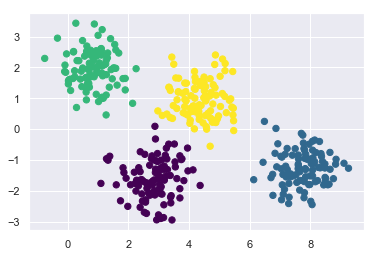

In [36]:
plt.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis')

k-means模型本身没有度量簇的分配概率或不确定性的方法。

In [37]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [50]:
def plot_kmeans(kmeans, x, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(x)
    
    # 画出输入数据
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    
    # 画出k-means模型的表示
    centers = kmeans.cluster_centers_
    radii = [cdist(x[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [51]:
kmeans = KMeans(n_clusters=4, random_state=0)

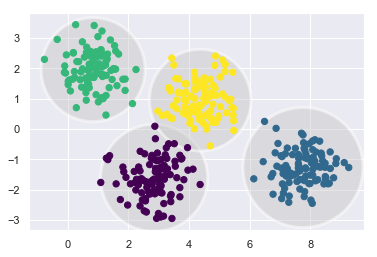

In [52]:
plot_kmeans(kmeans, x)

k-means算法对非圆形聚类效果很差

In [53]:
rng = np.random.RandomState(13)

In [54]:
x_stretched = np.dot(x, rng.randn(2, 2))

In [55]:
kmeans = KMeans(n_clusters=4, random_state=0)

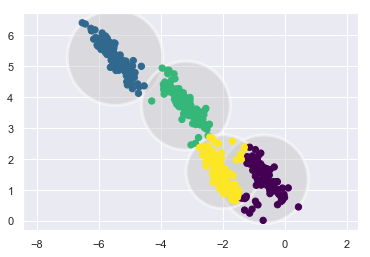

In [56]:
plot_kmeans(kmeans, x_stretched)

## 5.12.2 一般化E-M：高斯混合模型

In [58]:
from sklearn.mixture import GaussianMixture

In [59]:
gmm = GaussianMixture(n_components=4).fit(x)

In [60]:
labels = gmm.predict(x)

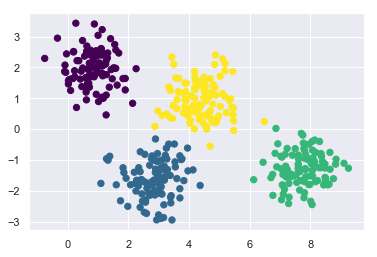

In [61]:
plt.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis')

In [62]:
probs = gmm.predict_proba(x)

In [64]:
print(probs[:5].round(3))

[[0.    0.    0.469 0.531]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]]


可视化不确定性

In [65]:
# 平方强调差异
size = 50 * probs.max(1) ** 2

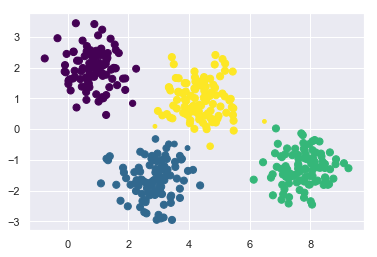

In [66]:
plt.scatter(x[:, 0], x[:, 1], c=labels, cmap='viridis', s=size)

In [67]:
from matplotlib.patches import Ellipse

In [68]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """用给定的位置和协方差画一个椭圆"""
    ax = ax or plt.gca()
    
    # 将协方差转换为主轴
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle=0
        width, height = 2 * np.sqrt(covariance)
        
    # 画出椭圆
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [75]:
def plot_gmm(gmm, x, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(x).predict(x)
    if label:
        ax.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(x[:, 0], x[:, 1], s=40, zorder=2)
    
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [76]:
gmm = GaussianMixture(n_components=4, random_state=42)

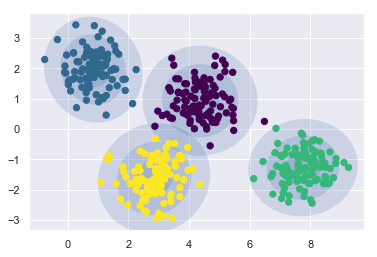

In [78]:
plot_gmm(gmm, x)

In [81]:
gmm.weights_

array([0.25454734, 0.24963804, 0.24878736, 0.24702726])

In [83]:
gmm.covariances_

array([[[ 0.40398685, -0.00235346],
        [-0.00235346,  0.36933794]],

       [[ 0.29768676, -0.02444193],
        [-0.02444193,  0.34173529]],

       [[ 0.36530305,  0.01293533],
        [ 0.01293533,  0.28921965]],

       [[ 0.38465995,  0.02716798],
        [ 0.02716798,  0.37394003]]])

In [85]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)

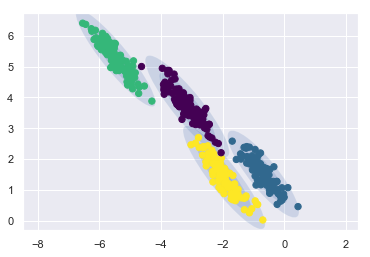

In [86]:
plot_gmm(gmm, x_stretched)

## 5.12.3 将GMM用作密度估计

In [87]:
from sklearn.datasets import make_moons

In [88]:
xmoon, ymoon= make_moons(200, noise=0.05, random_state=0)

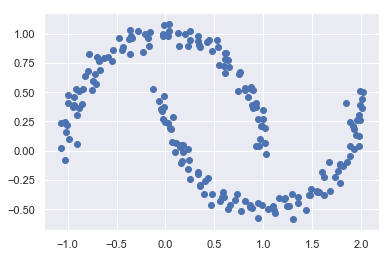

In [89]:
plt.scatter(xmoon[:, 0], xmoon[:, 1])

In [132]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)

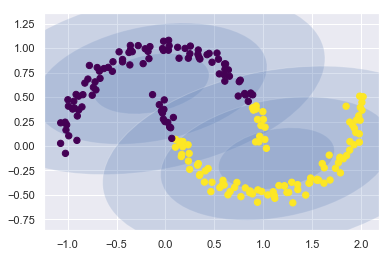

In [133]:
plot_gmm(gmm2, xmoon)

In [134]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)

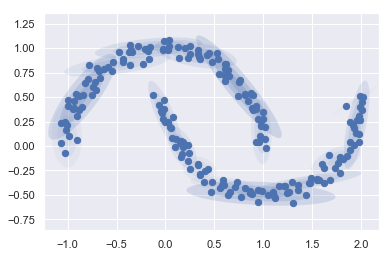

In [135]:
plot_gmm(gmm16, xmoon, label=False)

In [136]:
xnew = gmm16.sample(400)

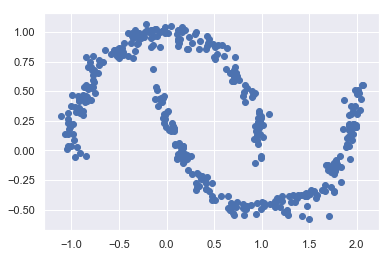

In [137]:
plt.scatter(xnew[0][:, 0], xnew[0][:, 1])

In [138]:
n_components = np.arange(1, 21)

In [139]:
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(xmoon) for n in n_components]

([<matplotlib.axis.XTick at 0x2b594ba8>,
 <a list of 20 Text xticklabel objects>)

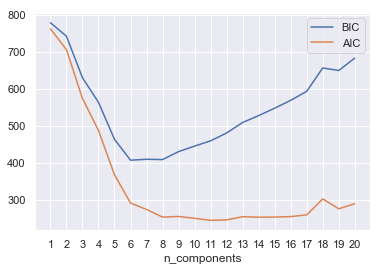

In [140]:
plt.plot(n_components, [m.bic(xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)

成分数量的选择度量的是GMM作为一个密度评估器的性能，而不是作为一个聚类算法的性能。GMM是一个密度评估器，仅在简单数据集中才将它作为聚类算法使用。

## 5.12.4 示例：用GMM生成新的数据

为前面使用过的标准手写数字库生成新的手写数字。

In [141]:
from sklearn.datasets import load_digits

In [142]:
digits = load_digits()

In [143]:
digits.data.shape

(1797, 64)

In [144]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

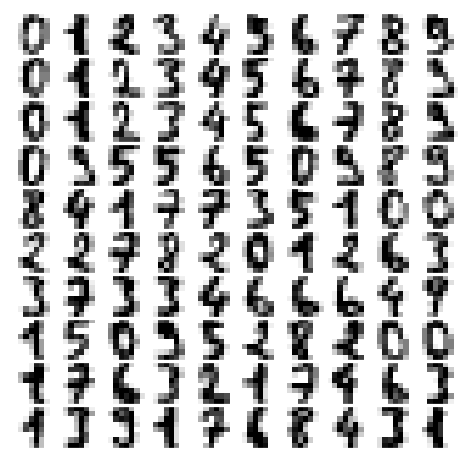

In [145]:
plot_digits(digits.data)

In [176]:
from sklearn.decomposition import PCA

In [177]:
pca = PCA(0.99, whiten=True)

In [178]:
data = pca.fit_transform(digits.data)

In [179]:
data.shape

(1797, 41)

降维后，几乎没有信息损失。再对这个投影数据使用AIC，从而得到GMM成分数量的粗略估计。

In [183]:
n_components = np.arange(50, 250, 10)

In [184]:
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]

In [185]:
aics = [model.fit(data).aic(data) for model in models]

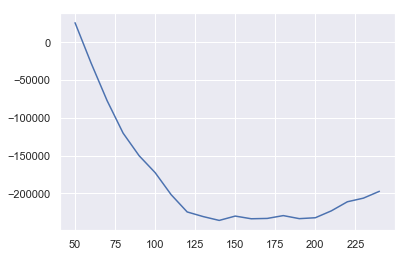

In [186]:
plt.plot(n_components, aics)

In [187]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)

In [188]:
gmm.fit(data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=110, n_init=1,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [189]:
gmm.converged_

True

In [190]:
data_new = gmm.sample(100)

In [191]:
data_new[0].shape

(100, 41)

最后通过PCA对象逆变换来构建新的数字

In [194]:
digits_new = pca.inverse_transform(data_new[0])

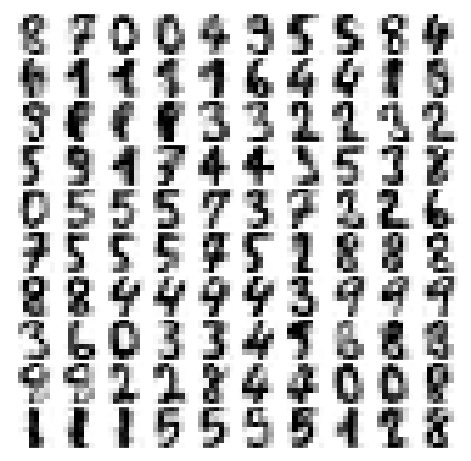

In [195]:
plot_digits(digits_new)